In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q open3d

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Capstone/Test3/Test3-2__git

/content/drive/MyDrive/Capstone/Test3/Test3-2__git


In [ ]:
!pip install yacs -q
!pip install gdown -q
!pip install plotly -q

In [ ]:
import os, sys, time
import argparse
import importlib
from tqdm.notebook import tqdm
from imageio import imread
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2


### Download pretrained
- We use HoHoNet w/ hardnet encoder in this demo
- Download other version [here](https://drive.google.com/drive/folders/1raT3vRXnQXRAQuYq36dE-93xFc_hgkTQ?usp=sharing)

In [ ]:
PRETRAINED_PTH = 'ckpt/mp3d_layout_HOHO_layout_aug_efficienthc_Transen1_resnet34/ep300.pth'

if not os.path.exists(PRETRAINED_PTH):
    os.makedirs(os.path.split(PRETRAINED_PTH)[0], exist_ok=True)
    !gdown 'https://drive.google.com/uc?id=1OU9uyuNiswkPovJuvG3sevm3LqHJgazJ' -O $PRETRAINED_PTH

### Download image
- We use a out-of-distribution image from PanoContext

In [ ]:
!pip install Pillow==9.0.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


<ipython-input-7-b7b0565795ba>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb = imread('/content/drive/MyDrive/Capstone/input/006/crop_pano/44304216.png')


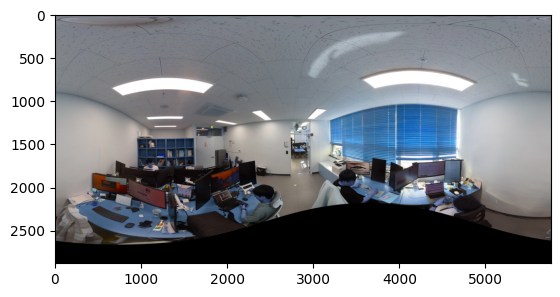

In [ ]:
rgb = imread('/content/drive/MyDrive/Capstone/input/006/crop_pano/44304216.png')

plt.imshow(rgb)
plt.show()
rgb = cv2.resize(rgb, (1024, 512), interpolation=cv2.INTER_LINEAR)


### Load model config
- We use HoHoNet w/ hardnet encoder in this demo
- Find out other version in `mp3d_depth/` and `s2d3d_depth`

In [ ]:
from lib.config import config

config.defrost()
config.merge_from_file('config/mp3d_layout/HOHO_layout_aug_efficienthc_Transen1_resnet34.yaml')
config.freeze()

### Load model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('devcie:', device)

model_file = importlib.import_module(config.model.file)
model_class = getattr(model_file, config.model.modelclass)
net = model_class(**config.model.kwargs)
net.load_state_dict(torch.load(PRETRAINED_PTH, map_location=device))
net = net.eval().to(device)

devcie: cpu


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Move image into tensor, normzlie to [0, 255], resize to 512x1024

In [ ]:
x = torch.from_numpy(rgb).permute(2,0,1)[None].float() / 255.
if x.shape[2:] != (512, 1024):
    x = torch.nn.functional.interpolate(x, size=(512, 1024), mode='area')
    print("fitting")
x = x.to(device)

### Model feedforward

In [ ]:
with torch.no_grad():
    ts = time.time()
    layout = net.infer(x)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    print(f'Eps time: {time.time() - ts:.2f} sec.')

cor_id = layout['cor_id']
y_bon_ = layout['y_bon_']
y_cor_ = layout['y_cor_']

Eps time: 2.79 sec.


### Visualize result in 2d

In [ ]:
from eval_layout import layout_2_depth

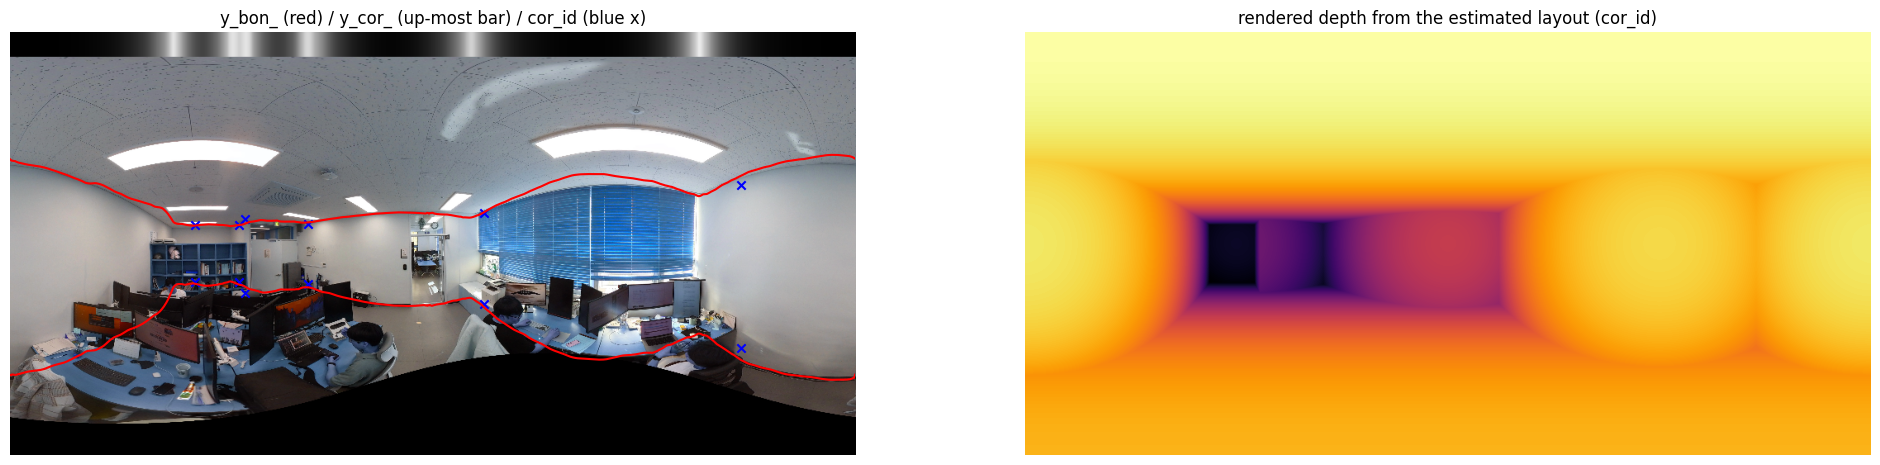

In [ ]:
plt.figure(figsize=(24,10))

plt.subplot(121)
plt.imshow(np.concatenate([
    (y_cor_ * 255).reshape(1,-1,1).repeat(30, 0).repeat(3, 2).astype(np.uint8),
    rgb[30:]
], 0))
plt.plot(np.arange(y_bon_.shape[1]), y_bon_[0], 'r-')
plt.plot(np.arange(y_bon_.shape[1]), y_bon_[1], 'r-')
plt.scatter(cor_id[:, 0], cor_id[:, 1], marker='x', c='b')
plt.axis('off')
plt.title('y_bon_ (red) / y_cor_ (up-most bar) / cor_id (blue x)')

plt.subplot(122)
plt.imshow(layout_2_depth(cor_id, *rgb.shape[:2]), cmap='inferno_r')
plt.axis('off')
plt.title('rendered depth from the estimated layout (cor_id)')

plt.show()

In [ ]:
# depth = layout_2_depth(cor_id, *rgb.shape[:2])

In [1]:
#@title 512X1024 이미지에서 문의 위치 적어주기 
#@markdown #### 높이가 door_x이고, 가로가 door_y이다. 맨 처음 코딩할 때 잘못 시작했다.
door_x = 256 #@param{type:"integer"}
door_y = 512 #@param{type:"integer"}

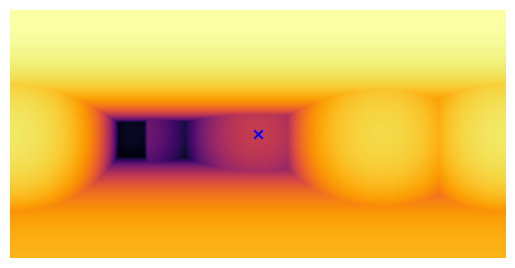

3.0961382
x, y, depth


In [ ]:
# layout['cor_id'] -> depth map 값 알아내기

plt.imshow(layout_2_depth(cor_id, *rgb.shape[:2]), cmap='inferno_r')
plt.scatter(512, 256, marker='x', c='b')
plt.axis('off')
plt.show()
door_id=np.array([[223.13266, 232.91037],
       [223.13266, 302.03738],
       [884.50287, 381.75412]])

# depth_values = layout_2_depth(cor_id, *rgb.shape[:2])[cor_id[:, 1].astype(np.int), cor_id[:, 0].astype(np.int)] # y, x
door_depth = layout_2_depth(door_id, *rgb.shape[:2])[door_x,door_y]
print(door_depth)
print('x, y, depth')
# for i in range(door_id.shape[0]):
#   print(door_id[i, 0], door_id[i, 1], depth_values[i])

### Visualize result as 3d mesh

In [ ]:
import inspect

def npinfo(*args):
  frame = inspect.currentframe().f_back
  for variable in args:
      name = [k for k, v in frame.f_locals.items() if v is variable]
      if len(name) == 1:
          name = name[0]
          print(f"{name}: {variable}")
      else:
          pass
      print("type: ", type(variable))
      print("shape: ", variable.shape)
      print(variable)

In [ ]:
import open3d as o3d
import plotly.graph_objects as go
from scipy.signal import correlate2d
from scipy.ndimage import shift
from skimage.transform import resize

from lib.misc.post_proc import np_coor2xy, np_coorx2u, np_coory2v

In [ ]:
# source code
H, W = 256, 512
ignore_floor = False
ignore_ceiling = False
ignore_wall = False

In [ ]:
# source code
# Convert corners to layout
depth, floor_mask, ceil_mask, wall_mask = [
    resize(v, [H, W], order=0, preserve_range=True).astype(v.dtype)
    for v in layout_2_depth(cor_id, *rgb.shape[:2], return_mask=True)]

In [ ]:
door_x_resized = int(door_x*(W/1024))
door_y_resized = int(door_y*(H/512))
print(door_x, door_y)

256 512


In [ ]:
obj_list = [depth, floor_mask, ceil_mask, wall_mask]
for obj in obj_list:
  npinfo(obj)


type:  <class 'numpy.ndarray'>
shape:  (256, 512)
[[0.76033914 0.76033914 0.76033914 ... 0.76033914 0.76033914 0.76033914]
 [0.76048225 0.76048225 0.76048225 ... 0.76048225 0.76048225 0.76048225]
 [0.7607401  0.7607401  0.7607401  ... 0.7607401  0.7607401  0.7607401 ]
 ...
 [1.6006166  1.6006166  1.6006166  ... 1.6006166  1.6006166  1.6006166 ]
 [1.6001947  1.6001947  1.6001947  ... 1.6001947  1.6001947  1.6001947 ]
 [1.6000204  1.6000204  1.6000204  ... 1.6000204  1.6000204  1.6000204 ]]
type:  <class 'numpy.ndarray'>
shape:  (256, 512)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
type:  <class 'numpy.ndarray'>
shape:  (256, 512)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False 

In [ ]:
# source code
coorx, coory = np.meshgrid(np.arange(W), np.arange(H)) #256,512
us = np_coorx2u(coorx, W) # -pi ~ pi
vs = np_coory2v(coory, H) # -1/2*pi ~ 1/2*pi
zs = depth * np.sin(vs) 
cs = depth * np.cos(vs)
xs = cs * np.sin(us)
ys = -cs * np.cos(us) # 전부다 사이즈 256.512

# Aggregate mask
mask = np.ones_like(floor_mask)
if ignore_floor:
    mask &= ~floor_mask
if ignore_ceiling:
    mask &= ~ceil_mask
if ignore_wall:
    mask &= ~wall_mask


In [ ]:
coorx

array([[  0,   1,   2, ..., 509, 510, 511],
       [  0,   1,   2, ..., 509, 510, 511],
       [  0,   1,   2, ..., 509, 510, 511],
       ...,
       [  0,   1,   2, ..., 509, 510, 511],
       [  0,   1,   2, ..., 509, 510, 511],
       [  0,   1,   2, ..., 509, 510, 511]])

In [ ]:
npinfo(coorx)
npinfo(coory)
npinfo(cs)

type:  <class 'numpy.ndarray'>
shape:  (256, 512)
[[  0   1   2 ... 509 510 511]
 [  0   1   2 ... 509 510 511]
 [  0   1   2 ... 509 510 511]
 ...
 [  0   1   2 ... 509 510 511]
 [  0   1   2 ... 509 510 511]
 [  0   1   2 ... 509 510 511]]
coory: [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [253 253 253 ... 253 253 253]
 [254 254 254 ... 254 254 254]
 [255 255 255 ... 255 255 255]]
type:  <class 'numpy.ndarray'>
shape:  (256, 512)
[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [253 253 253 ... 253 253 253]
 [254 254 254 ... 254 254 254]
 [255 255 255 ... 255 255 255]]
cs: [[0.00466535 0.00466535 0.00466535 ... 0.00466535 0.00466535 0.00466535]
 [0.01399799 0.01399799 0.01399799 ... 0.01399799 0.01399799 0.01399799]
 [0.02333555 0.02333555 0.02333555 ... 0.02333555 0.02333555 0.02333555]
 ...
 [0.0490986  0.0490986  0.0490986  ... 0.0490986  0.0490986  0.0490986 ]
 [0.02945435 0.0

In [ ]:
# source code
# Prepare ply's points and faces
xyzrgb = np.concatenate([
    xs[...,None], ys[...,None], zs[...,None],
    resize(rgb, [H, W])], -1)
xyzrgb = np.concatenate([xyzrgb, xyzrgb[:,[0]]], 1) # 수평선으로 폐쇄된 mesh를 만들기 위한 것.


In [ ]:
# source code
mask = np.concatenate([mask, mask[:,[0]]], 1)
npinfo(mask)

mask: [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
type:  <class 'numpy.ndarray'>
shape:  (256, 513)
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [ ]:
# source code
lo_tri_template = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 1, 1]])
up_tri_template = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [0, 0, 1]])
ma_tri_template = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [0, 1, 0]])
lo_mask = (correlate2d(mask, lo_tri_template, mode='same') == 3)
up_mask = (correlate2d(mask, up_tri_template, mode='same') == 3)
ma_mask = (correlate2d(mask, ma_tri_template, mode='same') == 3) & (~lo_mask) & (~up_mask)
ref_mask = (
    lo_mask | (correlate2d(lo_mask, np.flip(lo_tri_template, (0,1)), mode='same') > 0) |\
    up_mask | (correlate2d(up_mask, np.flip(up_tri_template, (0,1)), mode='same') > 0) |\
    ma_mask | (correlate2d(ma_mask, np.flip(ma_tri_template, (0,1)), mode='same') > 0)
) # ref_mask : 256x513


In [ ]:
lo_mask2 = correlate2d(mask, lo_tri_template, mode='same')

In [ ]:
lo_mask2

array([[3, 3, 3, ..., 3, 3, 2],
       [3, 3, 3, ..., 3, 3, 2],
       [3, 3, 3, ..., 3, 3, 2],
       ...,
       [3, 3, 3, ..., 3, 3, 2],
       [3, 3, 3, ..., 3, 3, 2],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
ma_mask.sum()

0

In [ ]:
ref_mask.sum()

131328

In [ ]:
np.flip(lo_tri_template, (0,1))

array([[1, 1, 0],
       [0, 1, 0],
       [0, 0, 0]])

In [ ]:
# source code
points = xyzrgb[ref_mask]

ref_id = np.full(ref_mask.shape, -1, np.int32)

In [ ]:
# source code

ref_id[ref_mask] = np.arange(ref_mask.sum())


In [ ]:
npinfo(ref_id)

ref_id: [[     0      1      2 ...    510    511    512]
 [   513    514    515 ...   1023   1024   1025]
 [  1026   1027   1028 ...   1536   1537   1538]
 ...
 [129789 129790 129791 ... 130299 130300 130301]
 [130302 130303 130304 ... 130812 130813 130814]
 [130815 130816 130817 ... 131325 131326 131327]]
type:  <class 'numpy.ndarray'>
shape:  (256, 513)
[[     0      1      2 ...    510    511    512]
 [   513    514    515 ...   1023   1024   1025]
 [  1026   1027   1028 ...   1536   1537   1538]
 ...
 [129789 129790 129791 ... 130299 130300 130301]
 [130302 130303 130304 ... 130812 130813 130814]
 [130815 130816 130817 ... 131325 131326 131327]]


In [ ]:
# arrays = [np.random.randn(3, 4) for _ in range(10)]
# print(arrays)
# npinfo(np.stack(arrays, axis=1))


In [ ]:
# npinfo(lo_mask)
# npinfo(ref_id[lo_mask])
# npinfo(ref_id[shift(lo_mask, [1, 0], cval=False, order=0)])
# npinfo(shift(lo_mask, [1, 0], cval=False, order=0))
# npinfo(shift(lo_mask, [1, 1], cval=False, order=0))

In [ ]:
# source code
faces_lo_tri = np.stack([
    ref_id[lo_mask],
    ref_id[shift(lo_mask, [1, 0], cval=False, order=0)],
    ref_id[shift(lo_mask, [1, 1], cval=False, order=0)],
], 1)
faces_up_tri = np.stack([
    ref_id[up_mask],
    ref_id[shift(up_mask, [1, 1], cval=False, order=0)],
    ref_id[shift(up_mask, [0, 1], cval=False, order=0)],
], 1)
faces_ma_tri = np.stack([
    ref_id[ma_mask],
    ref_id[shift(ma_mask, [1, 0], cval=False, order=0)],
    ref_id[shift(ma_mask, [0, 1], cval=False, order=0)],
], 1)
faces = np.concatenate([faces_lo_tri, faces_up_tri, faces_ma_tri])

In [ ]:
arr=np.array([[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]])
kernel = np.array([[True, True, True, True, True, True, True, True, True, False],
                   [True, True, True, True, True, True, True, True, True, False]])
arr[kernel]

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
#@title 잘 작동하나 더 확실한 방법을 찾아 쓰지 않음 (주석처리)
# # Convert the 2D RGB image point to 3D layout coordinate
# door_x, door_y, door_depth = 128, 256, 3.09  # example point
# coorx, coory = np.meshgrid(np.arange(W), np.arange(H))
# u = np_coorx2u(coorx[128,256], W) # 값: 0.006
# v = np_coory2v(coory[128,256], H) # 값: -0.006
# z_3d = depth * np.sin(v)
# c = depth * np.cos(v)
# x_3d = c * np.sin(u)
# y_3d = -c * np.cos(u)

# print(u,v)
# print(x_3d, y_3d, z_3d)

In [ ]:
def get_door(x, y):
  door_coorx = xs[x, y]
  door_coory = ys[x, y]
  door_coorz = zs[x, y]
  vertex_i = np.array([door_coorx, door_coory, door_coorz])

  door_coorx = xs[x, y-1]
  door_coory = ys[x, y-1]
  door_coorz = zs[x, y-1]
  vertex_j = np.array([door_coorx, door_coory, door_coorz])

  door_coorx = xs[x+1, y]
  door_coory = ys[x+1, y]
  door_coorz = zs[x+1, y]
  vertex_k = np.array([door_coorx, door_coory, door_coorz])

  return vertex_i, vertex_j, vertex_k

In [ ]:
def get_faces(x,y,z): # 
  point_index = (door_x_resized-1)*(door_y_resized+1)+door_y_resized # 127*(512+1)+256 
  i=faces[,0]
  j=faces[door_x_resized*door_y_resized,1]
  k=faces[door_x_resized*door_y_resized,2]
  print(i,j,k)
  vertex_i = points[i,:3]
  vertex_j = points[j,:3]
  vertex_k = points[k,:3]
  print(vertex_i, vertex_j, vertex_k)
  return vertex_i, vertex_j, vertex_k

  
def get_normal_vector(p1, p2, p3):
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)
    normal = np.cross(v1, v2)
    normal = normal / np.linalg.norm(normal)
    return normal


In [ ]:
door_i, door_j, door_k = get_door(door_x_resized, door_y_resized)
# door_i, door_j, door_k = get_faces(door_coorx,door_coory,door_coorz)
print(door_i, door_j, door_k)

[ 0.01899877 -3.09627987 -0.01899913] [-0.01899806 -3.09616329 -0.01899842] [ 0.01899949 -3.09639641 -0.05700526]


In [ ]:
norm = get_normal_vector(door_i, door_j, door_k)
norm

array([-0.00306812, -0.99999059,  0.00306614])

In [ ]:
fig = go.Figure(
    data=[go.Mesh3d(
            x=points[:,0],
            y=points[:,1],
            z=points[:,2],
            i=faces[:,0],
            j=faces[:,1],
            k=faces[:,2],
            facecolor=points[:,3:][faces[:,0]]
        ),
        go.Scatter3d(
            x=[door_coorx],
            y=[door_coory],
            z=[door_coorz],
            mode='markers',
            marker=dict(
                size=5,
                color='red'
            )
        ),
        go.Scatter3d(
            x=[door_i[0], door_j[0],door_k[0]],
            y=[door_i[1], door_j[1],door_k[1]],
            z=[door_i[2], door_j[2],door_k[2]],
            mode='markers',
            marker=dict(
                size=1,
                color='lightgreen'
            )
        ),


        
        go.Cone(x=[door_coorx], y=[door_coory], z=[door_coorz],
                u=[norm[0]], v=[norm[1]], w=[norm[2]],
                sizemode='absolute', sizeref=0.5,
                anchor='tail', showlegend=False)
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

#Turn layout to opnen3d mesh

In [ ]:
# Prepare vertices and faces
vertices = o3d.utility.Vector3dVector(points[:, :3])
colors = o3d.utility.Vector3dVector(points[:, 3:] / 255.0)
triangles = o3d.utility.Vector3iVector(faces)

# Create mesh object
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = vertices
mesh.vertex_colors = colors
mesh.triangles = triangles
mesh.compute_vertex_normals()

# Visualize mesh
o3d.visualization.draw_plotly([mesh])


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
%pwd

'/content/drive/MyDrive/Capstone/Test3/Test3-2__git'

In [ ]:
# Save mesh to file
# o3d.io.write_triangle_mesh("/content/drive/MyDrive/Capstone/input/004_LotteCastle_1_Management_Office/Layout/270_mesh.obj", mesh)


#get pcd and align to mesh

In [ ]:
import open3d as o3d

# Load mesh from previous step
# mesh = o3d.io.read_triangle_mesh('mesh.ply')

# Load point cloud from .pcd file
pcd = o3d.io.read_point_cloud('assets/snapshot.pcd')

# Apply translation to point cloud if necessary
# pcd.translate([x, y, z])

# Downsample point cloud if necessary
# downsampled_pcd = pcd.voxel_down_sample(voxel_size=0.05)

# Convert the mesh to a point cloud
mesh_pcd = mesh.sample_points_uniformly(number_of_points=10000)


[Open3D WARNING] Read PCD failed: unable to open file: assets/snapshot.pcd


In [ ]:
# Visualize mesh
o3d.visualization.draw_plotly([mesh_pcd, pcd])


In [ ]:
# Set the initial transformation to the identity matrix
init = np.identity(4)

# Run the registration
reg_p2p = o3d.pipelines.registration.registration_icp(
    source=mesh_pcd, target=pcd, max_correspondence_distance=0.02,
    init=init, estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    criteria=o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6, relative_rmse=1e-6, max_iteration=30))


[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


In [ ]:
# Get the transformation matrix
transformation_matrix = reg_p2p.transformation


In [ ]:
transformation_matrix


array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:

# Transform the mesh using the transformation matrix
mesh.transform(transformation_matrix)


TriangleMesh with 131328 points and 261120 triangles.

In [ ]:
# Visualize pcd
o3d.visualization.draw_plotly([pcd, mesh])


Output hidden; open in https://colab.research.google.com to view.

In [ ]:


# Save the PointCloud object to a .pcd file
# o3d.io.write_point_cloud("assets/snapshot_src.pcd", mesh_pcd)
